# Getting Started with Transfer Learning in Python
This example shows how to fine-tune a pretrained GoogleNet network to classify a new collection of images. This process is called transfer learning and is usually much faster and easier than training a new network, because you can apply learned features to a new task using a smaller number of training images. 

Before starting, please ensure that you have downloaded the MerchData.zip, and MerchDataTest.jpg files from canvas and place them in the same directory as this notebook.

Note: This script uses some commands that may not work on windows or Mac. These commands have been tested and work fine on google colab but are linux native commands and thus may not work for you. They are all commands that are moving files around and thus if they don't work, please either make the file adjustments manually or run the code on google colab. 

In [15]:
#You can use a gpu to speed up training time. In colab go to runtime > "Change runtime type" > and select gpu
import tensorflow as tf
tf.test.gpu_device_name()

''

## Extract Data for training
First we have to collect and unpack our dataset. This command unzips the training data and moves it to the train directory. 

In [16]:
!unzip MerchData_py.zip
!mv MerchData train

Archive:  MerchData_py.zip
   creating: MerchData/Cap/
  inflating: MerchData/Cap/Hat_0.jpg  
  inflating: MerchData/Cap/Hat_123.jpg  
  inflating: MerchData/Cap/Hat_148.jpg  
  inflating: MerchData/Cap/Hat_173.jpg  
  inflating: MerchData/Cap/Hat_198.jpg  
  inflating: MerchData/Cap/Hat_222.jpg  
  inflating: MerchData/Cap/Hat_247.jpg  
  inflating: MerchData/Cap/Hat_272.jpg  
  inflating: MerchData/Cap/Hat_297.jpg  
  inflating: MerchData/Cap/Hat_321.jpg  
  inflating: MerchData/Cap/Hat_346.jpg  
  inflating: MerchData/Cap/Hat_371.jpg  
  inflating: MerchData/Cap/Hat_49.jpg  
  inflating: MerchData/Cap/Hat_74.jpg  
  inflating: MerchData/Cap/Hat_99.jpg  
   creating: MerchData/Cube/
  inflating: MerchData/Cube/MathWorks_cube_0.jpg  
  inflating: MerchData/Cube/MathWorks_cube_1099.jpg  
  inflating: MerchData/Cube/MathWorks_cube_120.jpg  
  inflating: MerchData/Cube/MathWorks_cube_1300.jpg  
  inflating: MerchData/Cube/MathWorks_cube_1402.jpg  
  inflating: MerchData/Cube/MathWorks_cu

## Split dataset for training and validation
We need to set aside some portion of the dataset to use for validation.

In [17]:
from glob import glob
from sklearn.model_selection import train_test_split

## Randomly Split data into training and validation
# This code randomly chooses 25% of the training data to be set 
# aside for validation, and then creates a val folder with that set of data.
# feel free to do this yourself ahead of time if the cell doesn't work for you. 

dirs = glob('train/*')
print(dirs)
caps = glob('train/Cap/*.jpg')
cubes = glob('train/Cube/*.jpg')
cards = glob('train/PlayingCards/*.jpg')
screwdrivers = glob('train/Screwdriver/*.jpg')
torches = glob('train/Torch/*.jpg')

# The *_val variables contain the filenames of the files chosen for validation. 
caps_train, caps_val = train_test_split(caps, test_size=0.25)
cubes_train, cubes_val = train_test_split(cubes, test_size=0.25)
cards_train, cards_val = train_test_split(cards, test_size=0.25)
sd_train, sd_val = train_test_split(screwdrivers, test_size=0.25)
torches_train, torches_val = train_test_split(torches, test_size=0.25)

TRAIN_DIR = 'train'
VAL_DIR = 'val'

# This code moves the validation files out of the train directory and over to 
# the val directory.
!mkdir val

!mkdir val/Cap
files = ' '.join(caps_val)
!mv -t val/Cap $files

!mkdir val/Cube
files = ' '.join(cubes_val)
!mv -t val/Cube $files

!mkdir val/PlayingCard
files = ' '.join(cards_val)
!mv -t val/PlayingCard $files

!mkdir val/Screwdriver
files = ' '.join(sd_val)
!mv -t val/Screwdriver $files

!mkdir val/Torch
files = ' '.join(torches_val)
!mv -t val/Torch $files

['train/Torch', 'train/Cube', 'train/Screwdriver', 'train/Cap', 'train/PlayingCards']
mkdir: cannot create directory ‘val’: File exists
mkdir: cannot create directory ‘val/Cap’: File exists
mkdir: cannot create directory ‘val/Cube’: File exists
mkdir: cannot create directory ‘val/PlayingCard’: File exists
mkdir: cannot create directory ‘val/Screwdriver’: File exists
mkdir: cannot create directory ‘val/Torch’: File exists


In [18]:
# Jupyter keeps checkpoint files that may screw up the ImageDataGenerator class
# So we delete those here. 
!rm -rf train/.ipynb_checkpoints
!rm -rf val/.ipynb_checkpoints

## Augment Data for Training
The provided dataset is fairly small. We can increase the effective size of the dataset by performing some preprocessing augmentations. By scaling, rotating, and flipping the images, we can create new images to increase the size of our dataset and ensure that our model is invariant to these transformations. Keras has a built in class called [ImageDataGenerator](https://keras.io/api/preprocessing/image/) that allows us to perform these operations and more. 

In this case, we split the d
ata into training and validation, and allow for up to 90 degrees of rotation, and up to a doubling in zoom level as well as flipping across the y axis.


Keras provides the class ImageDataGenerator() for data augmentation. This class can be parametrized to implement several transformations, and our task will be decide which transformations make sense for our data. Images will be directly taken form our defined folder structure using the method flow_from_directory().

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input


TRAIN_DIR = 'train'
VAL_DIR = 'val'
WIDTH = 299
HEIGHT = 299
BATCH_SIZE = 11

# data prep
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=90,
    zoom_range=[1,2],
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=90,
    zoom_range=[1,2],
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
		batch_size=BATCH_SIZE,
		class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 30 images belonging to 5 classes.
Found 45 images belonging to 5 classes.


## Load Pre-trained model


We can load the pre-trained googlenet InceptionV3 Model directly from the keras.applications package. By specifying ```include_top=False```, we remove the final classification layers from the model. We will be replacing the top layers with our own. 

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

base_model = InceptionV3(weights='imagenet', include_top=False)

If you wish to see the structure of the InceptionV3 network, you can run the following cell. 

In [7]:
from tensorflow.keras.utils import plot_model
plot_model(base_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Replace classification layer

Here we add the final classification layers back to the network.

In [21]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout


CLASSES = 5
# These layers were removed by setting include_top=false, but we still want them
x = base_model.output                          # The output layer of the googleNet
x = GlobalAveragePooling2D(name='avg_pool')(x) # This layer is used to downsample the features
x = Dropout(0.4)(x)                            # This layer is used to enforce feature redundancy 

# This layer specifies our classifier output
predictions = Dense(CLASSES, activation='softmax')(x)
#
model = Model(inputs=base_model.input, outputs=predictions)



We only want to train the final layers of the network, so we set this flag to ensure that the pre-trained layers stay as they were.

In [22]:
for layer in base_model.layers:
    layer.trainable = False # Set this to True if you want to re-train the entire network.

Finally we compile our Model

In [23]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Train the network

In [24]:
EPOCHS = 30
BATCH_SIZE = 11
STEPS_PER_EPOCH = 5
VALIDATION_STEPS = 1
MODEL_FILE = 'filename.model'

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS)
  
model.save(MODEL_FILE)

Epoch 1/30
5/5 [==============================] - 29s 6s/step - loss: 1.7386 - accuracy: 0.3462 - val_loss: 1.7086 - val_accuracy: 0.2727
Epoch 2/30
5/5 [==============================] - 19s 4s/step - loss: 1.3856 - accuracy: 0.4565 - val_loss: 1.8873 - val_accuracy: 0.0909
Epoch 3/30
5/5 [==============================] - 22s 4s/step - loss: 1.2565 - accuracy: 0.4808 - val_loss: 1.5919 - val_accuracy: 0.2727
Epoch 4/30
5/5 [==============================] - 19s 4s/step - loss: 1.2179 - accuracy: 0.5918 - val_loss: 1.6756 - val_accuracy: 0.2727
Epoch 5/30
5/5 [==============================] - 21s 4s/step - loss: 0.9353 - accuracy: 0.7500 - val_loss: 1.4918 - val_accuracy: 0.2727
Epoch 6/30
5/5 [==============================] - 21s 4s/step - loss: 0.9407 - accuracy: 0.7143 - val_loss: 1.1841 - val_accuracy: 0.6364
Epoch 7/30
5/5 [==============================] - 21s 4s/step - loss: 0.9847 - accuracy: 0.6538 - val_loss: 1.2294 - val_accuracy: 0.3636
Epoch 8/30
5/5 [==================

Now lets visualize how accuracy and loss changed with each epoch.


In /home/hp/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/hp/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/hp/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/hp/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/hp/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_tes

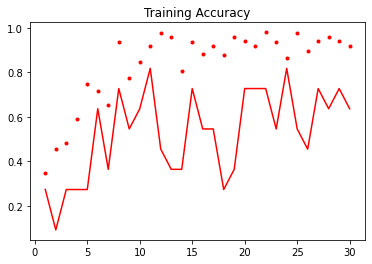

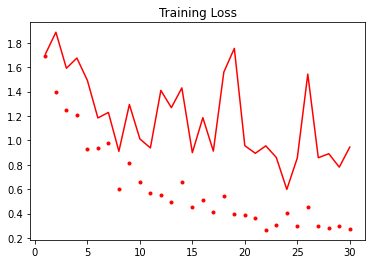

In [25]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

plt.plot(epochs, val_acc,'r')
plt.plot(epochs, acc,'r.')
plt.title("Training Accuracy")

plt.figure()
plt.plot(epochs, val_loss,'r')
plt.plot(epochs,loss,'r.')
plt.title("Training Loss")
plt.show()

## Test Trained Network

Finally, we can see how our trained network does classifying a new image. 

In [1]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Predict pre-processes the input so that it matches the format expected by the 
# network, then runs model.predict which provides the class predictions
def predict(model, img):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]

# We plot the original image
plt.figure()
img = image.load_img('MerchDataTest.jpg', target_size=(HEIGHT, WIDTH))
preds = predict(load_model(MODEL_FILE), img)
plt.imshow(img)

# We can visualize the predicted likelihood of each class
plt.figure()
labels = ["Cap", "Cube","Cards","Screwdriver","Torch"]
plt.barh(range(5),preds,alpha=0.5)
plt.yticks(range(5),labels)
plt.xlabel('Probability')
plt.xlim(0,1)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

NameError: name 'plt' is not defined

For a more in-depth tutorial on transfer learning, [click here](https://medium.com/abraia/first-steps-with-transfer-learning-for-custom-image-classification-with-keras-b941601fcad5)

